# Tutorial 1b: *Global Visualizations*

This tutorial is an introduction to analizing results from a global simulation.  It build on the case you just ran in the `Global_Simulations`, but do don't have to wait for those runs to complete before doing this tutorial too. We've prestaged the model results in a shared directory so that you can get started on this now.

## In this tutorial

The tutorial has several objectives: 
1. Start getting familiar with Jupyter Notebooks
2. Begin getting aquinted with python packages and their utilities
3. Compare results from two simulations, here CLM5.1-SP and CLM5.1_FATES-SP

***
**This tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see the [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 

---

You don't have to do anything to setup or run a Jupyter notebook, it's already configured for you in CESM-Lab.

<div class="alert alert-block alert-info">
<b>NOTE:</b> Previously, all our <b>To Do</b> tasks had do be done on the command-line.  In this tutorial you can directly execute the contents of code blocks by running individual cells in this Jupyter notebook, just like on the Day 0b <i>Run NEON</i> tutorial.
</div>

***

*We'll start by loading some packages*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
#from netCDF4 import num2date

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
%matplotlib inline

<div class="alert alert-block alert-warning">

<b>NOTICE:</b>  This example largely uses features of xarray and 
    matplotlib packages. We don't have time to go into the basics 
    of python or features in these packages, but there are lots of 
    resources to help get you started. We've listed some of these below. 

</div>

- [NCAR python tutorial](https://ncar.github.io/python-tutorial/tutorials/yourfirst.html), which introduces python, the conda package manager, and more on github.
- [NCAR ESDS tutorial series](https://ncar.github.io/esds/blog/tag/python-tutorial-series/), features a bunch of recorded tutorials on a wide variety of topics.
- [GeoCAT examples](https://geocat-examples.readthedocs.io/en/latest/), with some nice plotting examples
- TODO add more?

***

### First we need to point to our data

In [2]:
path = '/scratch/data/day1/'         # path to archived simulations
#path = '/glade/scratch/wwieder/archive/'         # path to archived simulations on cheyenne
cases = ['I2000_CTSM51_sp','I2000_CTSM_FATESsp'] # case names
years = list(range(2015,2020,1))                 # look at the last 5 years of data

# create a list of the files we'll open
# for now we'll create two different lists of files since they have different variables in the history file 
finCTSM  = [path+cases[0]+'/lnd/hist/'+cases[0]+'.clm2.h0.'+str(year)+'*' for year in years] 
finFATES = [path+cases[1]+'/lnd/hist/'+cases[1]+'.clm2.h0.'+str(year)+'*' for year in years] 

print(finCTSM[0])
finFATES[-1]

/scratch/data/day1/I2000_CTSM51_sp/lnd/hist/I2000_CTSM51_sp.clm2.h0.2015*


'/scratch/data/day1/I2000_CTSM_FATESsp/lnd/hist/I2000_CTSM_FATESsp.clm2.h0.2019*'

<div class="alert alert-block alert-info">
<b>NOTE:</b> These are the raw history files that CTSM writes out.  
They are grid cell, monthly means for different states and fluxes.
<br><br>
Typically we post-process these data to generate single variable time series for an experiment. 
This means that model output for each variable, like rain, air temperature, or latent heat flux, are each in their own file.
<br><br>
We'll work on a post-processing tutorial, but for now we'll just read in the monthly history files described above.

</div>

### Next we'll open the files

This is done with the xarray function `open_mfdataset`

To make this go faster, we're going to preprocess the data so we're just reading the variables we want to look at.

<div class="alert alert-block alert-info">
<b>TIP:</b> If you want to look at other variables, the cell below is where you can modify what we're reading off of the CTSM and CTSM-FATES history files.
<br><br>
</div>

Depending on what you're looking at, these variables of interest may have different names in CTSM and CTSM-FATES simulations.  Sorry, this is confusing, but FATES-specific variables all have a *FATES_* prefix. This reflects if the history variables is being calculated by FATES directly, or uses information from FATES, but ultimately calculated by the host land model (here CTSM). 
    
To begin with we'll look at albedo that's simulated by the two models. Albedo and can be calculated in several different ways, but they all use solar radiation terms are handled within CTS .  Here we'll look at 'all sky albedo', which is reflected / incoming solar radiation (**FSR/FSDS**) Other intereresting fields might be latent heat flux or gross primary productivity. **Note,** we're also going to include information about grid cell areas, as that's helpful for calculating globally weighted results 

In [3]:
## TODO, split each step appart with text box annotations for each?
# Define the variables to read in
fields = ['FSR','FSDS', 'ELAI','area','landfrac']

'''select the variables we want to read in'''
def preprocess(ds, fields=fields):
    return ds[fields]

''' quick fix to adjust time vector for monthly data'''
def fix_time(ds):  
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')    

    return ds


# Open the datasets
# Note, here we'll just read in a single year of data for efficiency
dsCTSM = fix_time(xr.open_mfdataset(finCTSM[0], decode_times=True, 
                                    preprocess=preprocess))
dsFATES = fix_time(xr.open_mfdataset(finFATES[0], decode_times=True, 
                                     preprocess=preprocess) )

dsFATES

<xarray.Dataset>
Dimensions:   (lat: 46, lon: 72, time: 12)
Coordinates:
  * time      (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon       (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat       (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
Data variables:
    FSR       (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    FSDS      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    ELAI      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    area      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    landfrac  (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
Attributes:
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/26/22 13:39:22
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    username:                             wwieder
    version:                              unknown
    revision_id:                          $Id: histFileMod.F90 42903 2012-12-...
    case_title:                           I2000_CTSM_FATESsp
    case_id:                              I2000_CTSM_FATESsp
    Surface_dataset:                      surfdata_4x5_hist_16pfts_Irrig_CMIP...
    Initial_conditions_dataset:           arbitrary initialization
    PFT_physiological_constants_dataset:  ctsm51_params.c211112.nc
    ltype_vegetated_or_bare_soil:         1
    ltype_crop:                           2
    ltype_UNUSED:                         3
    ltype_landice:                        4
    ltype_deep_lake:                      5
    ltype_wetland:                        6
    ltype_urban_tbd:                      7
    ltype_urban_hd:                       8
    ltype_urban_md:                       9
    ctype_vegetated_or_bare_soil:         1
    ctype_crop:                           2
    ctype_crop_noncompete:                2*100+m, m=cft_lb,cft_ub
    ctype_landice:                        4*100+m, m=1,glcnec
    ctype_deep_lake:                      5
    ctype_wetland:                        6
    ctype_urban_roof:                     71
    ctype_urban_sunwall:                  72
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./I2000_CTSM_FATESsp.clm2.h0.2000-0...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

#### Printing information on dataset we've read is helpful for understanding your data. 
- *What dimensions do your data have?*
- *What are the coordinate variables?*
- *What variables are we looking at?*
- *Is there other helpful information, or attributes in the dataset we should be aware of?*


---

You can also print information about the variables in your dataset.

This can be done with the example below:

In [4]:
dsFATES.FSDS

<xarray.DataArray 'FSDS' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
Attributes:
    long_name:      atmospheric incident solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

*What are the units, long name, and dimensions of your data?*

Modify this cell with some of the other variables in your dataset?

---

#### Combining datasets
Next, since our CTSM-FATESsp and CTSM5.1-SP have the same variables, we'll 
1. Combine them into a single dataset using the xarray function `concat` along a new dimensions that we'll introduce for each simulation, `sim`. 
2. Assign corrdinates to the 'sim' dimension


In [5]:
ds = xr.concat([dsCTSM,dsFATES], 'sim',data_vars='all')
ds = ds.assign_coords(sim=("sim", ['CTSM5.1-sp','CTSM-FATESsp']))
dsFATES.FSDS

<xarray.DataArray 'FSDS' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
Attributes:
    long_name:      atmospheric incident solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

#### Additional, derived variables can be added to the dataset

Calculate the all sky albedo as a new variable in the dataset and add appropriate metadata.

*Also, avoid dividing by zero using `.where` function*

In [6]:
ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS>0)
ds['ASA'].attrs['units'] = 'unitless'
ds['ASA'].attrs['long_name'] = 'All sky albedo'

---
#### Xarray makes quick plots of the data easy to make.  
- Here we can just look at a month of data from the two simulations, using the `.isel` function.
- More examples are on the [xarray web site](https://docs.xarray.dev/en/latest/user-guide/plotting.html)

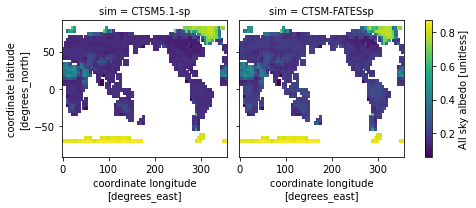

In [7]:
ds.ASA.isel(time=6).plot(x='lon',y='lat',col="sim", col_wrap=2) ;

Here for each month, from a single simulation

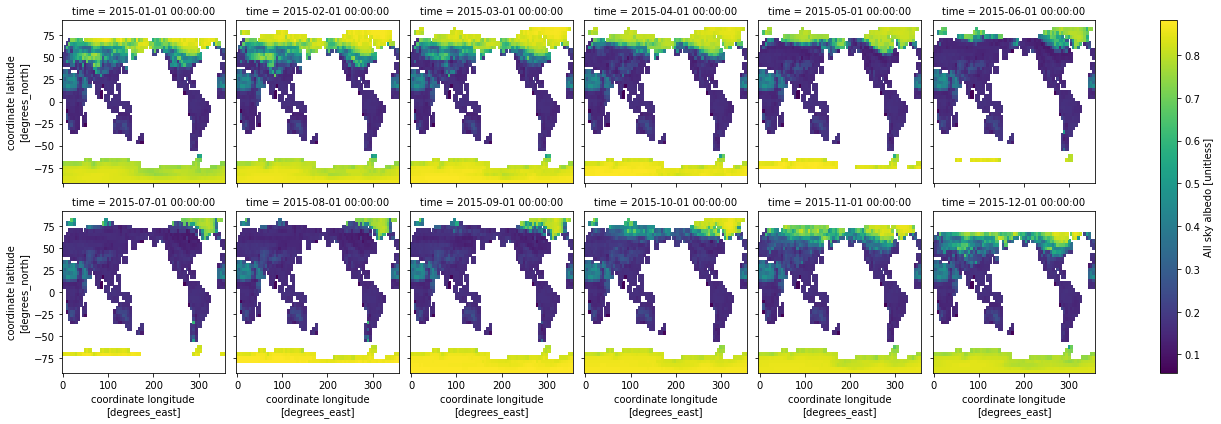

In [8]:
ds.ASA.isel(sim=0).plot(x='lon',y='lat',col="time", col_wrap=6) ;

**Think:** 
- Why don't you see the whole globe in each panel?

---

Next we're really interested in the differences between the simulations, let's have a look:

### We can also look at a *time series*
- This examples uses the `.sel` function to look at a single point for a point in the Amazon
- Below, we'll also use subplots to see multiple variables in several panels

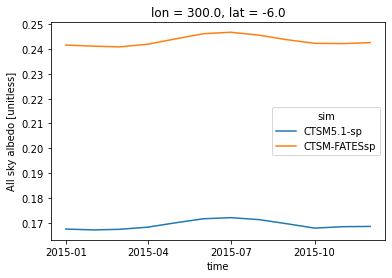

In [9]:
point = ds.sel(lon=300, lat=-5, method='nearest')
point.ASA.plot(hue='sim',x='time') ;

**Think:** 
- Why is albedo in these simulations so different?
- What could cause these differences in albedo in two simulations that are seeing idential climate and should have the same prescribed leaf area index (LAI)?

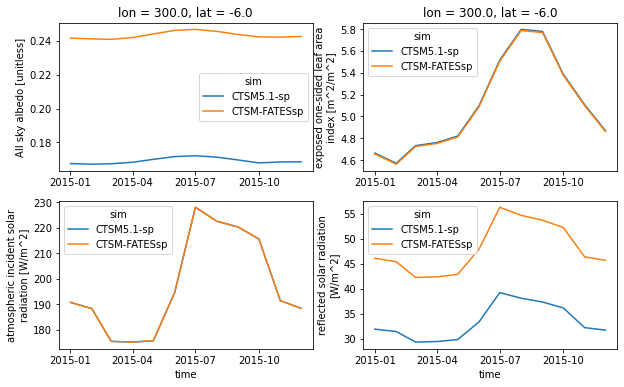

In [10]:
plt.figure(figsize=(10,6))
'''this first plot is the same as the one above'''
plt.subplot(221)
point.ASA.plot(hue='sim',x='time')
plt.xlabel(None)

'''now we'll look for potential sources of the difference'''
plt.subplot(222)
point.ELAI.plot(hue='sim',x='time') 
plt.xlabel(None)

plt.subplot(223)
point.FSDS.plot(hue='sim') 
plt.title(None)

plt.subplot(224)
point.FSR.plot(hue='sim') 
plt.title(None) ;

**Look** 
- Are the simulations seeing the same input data?
- Is LAI be prescribed identically?
- What's driving the differences in albedo between FATES and CTSM5.1 simulations?
- **Is this happening elsewhere?**

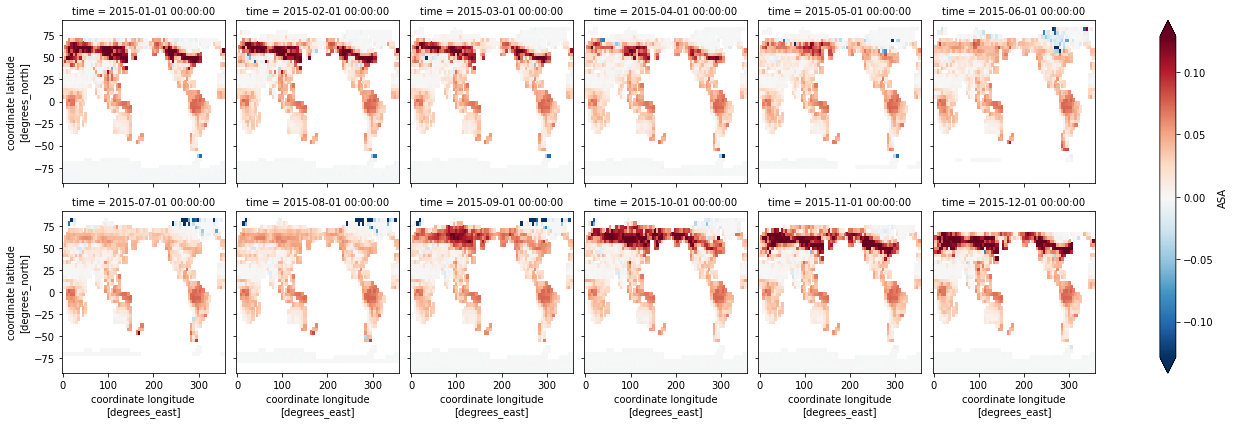

In [11]:
dsDiff = ds.isel(sim=1) - ds.isel(sim=0)
dsDiff.ASA.plot(x='lon',y='lat',col="time", col_wrap=6, robust=True) ;

**Look:** 
- How is albedo different in CTSM-FATESsp and CTSM5.1-sp?
- Where are the differences the largest? 
- Are the differences consistent throughout the year?
- What's driving the differences in albedo in different regions?

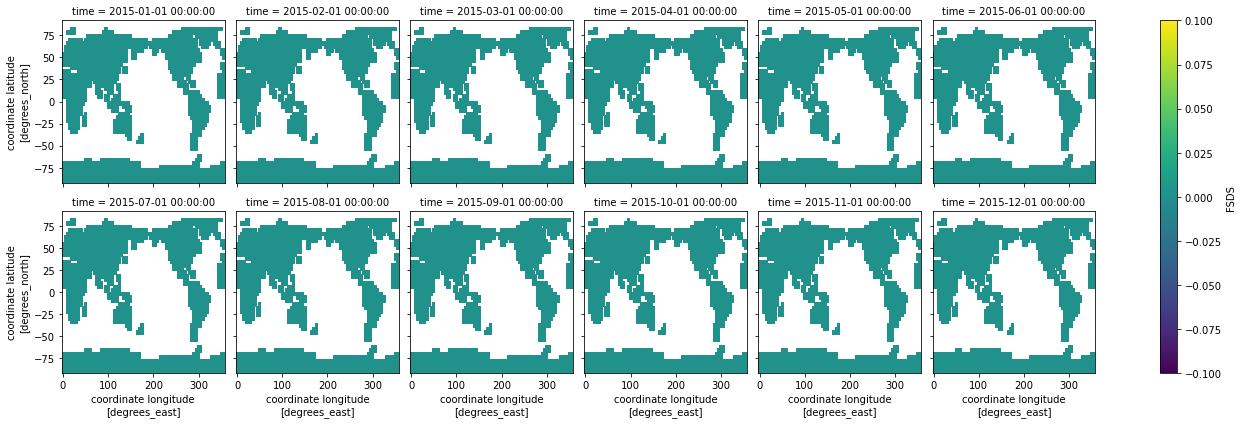

In [12]:
dsDiff.FSDS.plot(x='lon',y='lat',col="time", col_wrap=6, vmax=0.1,vmin=-0.1) ;

**Look:** 
- These differences in incoming solar are tiny


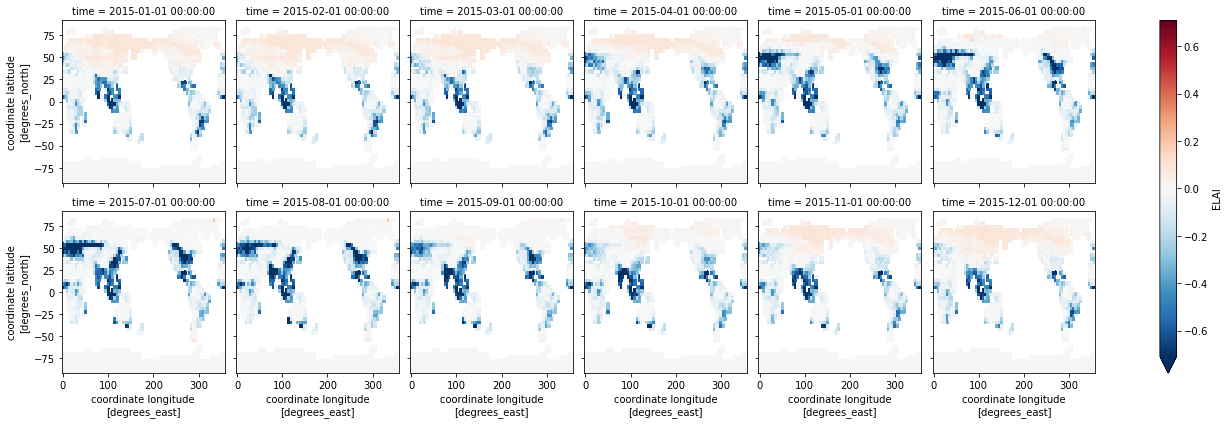

In [13]:
dsDiff.ELAI.plot(x='lon',y='lat',col="time", col_wrap=6, robust=True) ;

**Look:** 
- What regions are LAI differences the greatest
- What times of year is this true?

---
## Global time series
There are many cases that we may like to calculate global integrated time series for particular variables.
This should be pretty straightforward, but it requires weighting the values from each grid cell by the total land area of individual gridcells.  The example below does this for our dataset. 

We'll calculate a:
- land area `la` that's the product of land fraction and gridcell area, units are the same as area.
- land weights `lw` will be the fractional weight that each grid makes to the global total.  It should be larger near the equator, and smaller at the poles and coast

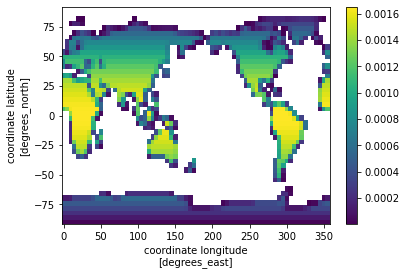

In [14]:
la = (ds.landfrac*ds.area).isel(time=0,sim=0).drop(['time','sim'])
la.attrs['units'] = ds.area.attrs['units']
lw = la/la.sum()
lw.plot() ;


### Calculate and plot a global weighted sum
<div class="alert alert-block alert-warning">

<b>NOTE:</b>  Other variables may make more sense to sum the global flux (e.g. global GPP as gC/unit time).  To do this you need to use the land area variable when calculating a global sum, <b>just remember pay attention to the units you're using!</b>

</div>


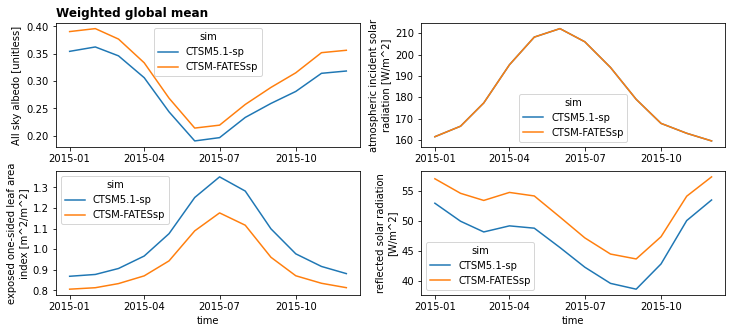

In [15]:
dsGlobalWgt = (ds * lw).sum(['lat','lon'])

plt.figure(figsize=(12,5))
plotVars = ['ASA','FSDS','ELAI','FSR']
for i in range(len(plotVars)):
    # First add metadata for plotting
    dsGlobalWgt[plotVars[i]].attrs['long_name'] = ds[plotVars[i]].attrs['long_name']
    dsGlobalWgt[plotVars[i]].attrs['units'] = ds[plotVars[i]].attrs['units']

    # then make plots
    plt.subplot(2,2,(i+1))
    dsGlobalWgt[plotVars[i]].plot(hue='sim')
    
    if i == 0:
        plt.title('Weighted global mean',loc='left', fontsize='large', fontweight='bold')
        
    if i<2:
        plt.xlabel(None)

---
## Calculate and plot an annual weighted mean
This examples walk through calculating annual averages, 
that are weighted for the number of days per month.

1. First we'll define a function to do this with.
2. Then we'll make a nice plot of the results.

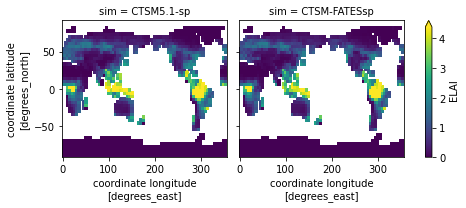

In [16]:
# generate annual means, weighted by days / month
def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

for i in range(len(plotVars)):
    temp = weighted_annual_mean(
        ds[plotVars[i]].chunk({"time": 12}))
    
    if i ==0:
        dsAnn = temp.to_dataset(name=plotVars[i])
    else:
        dsAnn[plotVars[i]] = temp
        
dsAnn.ELAI.plot(x='lon',y='lat',col='sim',
               col_wrap=2, robust=True) ;

### Define function for plotting maps
This is kind of complicated function, but it allows you to make several pretty maps in one figure

Additional examples and information are available on the [cartopy website](https://scitools.org.uk/cartopy/docs/v0.15/index.html)

In [17]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy

# Generate a function for making panel plots of maps
## many of these features are not required, but provide additional control over plotting
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None,nbins=200):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    #cmap.set_bad( "gray", alpha=0.05 )
    #cmap.set_under( "white", alpha=1 )
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-56,85], crs=ccrs.PlateCarree())

    # add title & panel lables
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    #land = ax.add_feature(
    #    cfeature.NaturalEarthFeature('physical','land','110m', facecolor='grey',alpha=0.05))

    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')

#### Now make the plot!

/opt/ncar/conda/envs/default/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


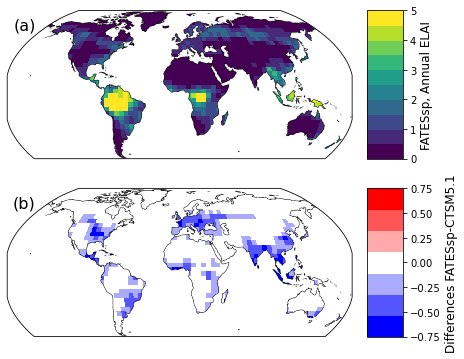

In [19]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    #i = index[0] 
    if i == 0:
        plotData = dsAnn.ELAI.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     vmax=5,vmin=0,
                     units='FATESsp, Annual ELAI')
    if i == 1:
        plotData = (dsAnn.ELAI.isel(sim=1,time=0)- \
                    dsAnn.ELAI.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     vmax=0.75,vmin=-0.75)
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    

    i = i+1

## Extra credit challenge
If you have extra time & energy try running through this notebook with other variables.  Interesting options could include: 
- Canopy evapotranspiration (FCEV) or 
- GPP (`FSPN` in CLM5.1-sp and `FATES_GPP` in FATES)

<div class="alert alert-block alert-warning">

<b>HINT:</b> pay attention to units for these challenges.

</div>